In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [3]:

# Step 1: Data cleaning
data = yf.download(tickers='ETH-usd', start='2017-11-09', end='2023-02-28', interval='1d')
#data = yf.download(tickers='BTC-USD', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2023-02-23,1643.298584,1674.601562,1632.566162,1651.073853,1651.073853,9013236167
2023-02-24,1650.895142,1661.091309,1583.147827,1608.373169,1608.373169,8909129423
2023-02-25,1608.658325,1608.865112,1567.631714,1594.914917,1594.914917,5657686235


In [4]:
data = data.drop(['Close'], axis=1)
data

,Open,High,Low,Adj Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984
...,...,...,...,...,...
2023-02-23,1643.298584,1674.601562,1632.566162,1651.073853,9013236167
2023-02-24,1650.895142,1661.091309,1583.147827,1608.373169,8909129423
2023-02-25,1608.658325,1608.865112,1567.631714,1594.914917,5657686235


In [5]:
data= data.to_csv('ETH_case2.csv')

In [5]:
from datetime import datetime

def date_parser(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    return date_obj.strftime('%m-%d-%Y')


In [11]:
data_csv = pd.read_csv('ETH_case2.csv')
data_csv.dropna(inplace=True)
# Setting the index

data_csv.set_index('Date', inplace=True)
# Dropping any NaNs
data_csv.dropna(inplace=True)
data_csv.info()
data_csv.tail(10)

<class 'pandas.core.frame.DataFrame'>
Index: 1937 entries, 2017-11-09 to 2023-02-27
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1937 non-null   float64
 1   High       1937 non-null   float64
 2   Low        1937 non-null   float64
 3   Adj Close  1937 non-null   float64
 4   Volume     1937 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 90.8+ KB


,Open,High,Low,Adj Close,Volume
Date,,,,,
2023-02-18,1694.741821,1705.309082,1683.670166,1691.819458,5491437195
2023-02-19,1691.680176,1718.947632,1673.906616,1681.436157,6959144003
2023-02-20,1682.337036,1716.489380,1659.295044,1702.675171,7703604237
2023-02-21,1702.797852,1714.285645,1642.396729,1658.036377,8721608198
2023-02-22,1658.140991,1663.996826,1604.803345,1643.231689,9189387004
2023-02-23,1643.298584,1674.601562,1632.566162,1651.073853,9013236167
2023-02-24,1650.895142,1661.091309,1583.147827,1608.373169,8909129423
2023-02-25,1608.658325,1608.865112,1567.631714,1594.914917,5657686235
2023-02-26,1594.761108,1645.273438,1590.393066,1640.817139,5727967432


In [12]:
# Split the data into training and test sets
train_df = data_csv[:int(len(data_csv)*0.8)]
test_df = data_csv[int(len(data_csv)*0.8):]
data_csv.shape


(1937, 5)

In [13]:
test_data =test_df.copy()

In [14]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()


In [15]:
print(train_df.info())
print(test_df.info())
print('test_data', test_data.shape)


<class 'pandas.core.frame.DataFrame'>
Index: 1549 entries, 2017-11-09 to 2022-02-04
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1549 non-null   float64
 1   High       1549 non-null   float64
 2   Low        1549 non-null   float64
 3   Adj Close  1549 non-null   float64
 4   Volume     1549 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 72.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 388 entries, 2022-02-05 to 2023-02-27
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       388 non-null    float64
 1   High       388 non-null    float64
 2   Low        388 non-null    float64
 3   Adj Close  388 non-null    float64
 4   Volume     388 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 18.2+ KB
None
test_data (388, 5)


In [16]:
# Preprocess the data
X_train = train_df.drop(['Adj Close'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)


x_train (1549, 4)
y_train (1549,)
X_test (388, 4)
y_test (388,)


In [17]:
scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test  = y_test.reshape(-1,1)
y_test  = scaler.fit_transform(y_test)
#------------------------------------------
print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape) 

x_train (1549, 4)
y_train (1549, 1)
X_test (388, 4)
y_test (388, 1)


In [18]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape)
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])


X_train (1549, 1, 4)
y_train (1549, 1)
X_test (388, 1, 4)
Y_test (388, 1)
X_train.shape[1] 1
X_train.shape[2] 4


In [19]:
# Step 6: Building the GRU model (cont.)

model = Sequential()
model.add(GRU(100, input_shape=( X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(75, return_sequences=True, activation='tanh'))
model.add(Dropout(0.25))
model.add(GRU(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['accuracy', 'mean_absolute_error'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 100)            31800     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 gru_1 (GRU)                 (None, 1, 100)            60600     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 gru_2 (GRU)                 (None, 1, 75)             39825     
                                                                 
 dropout_2 (Dropout)         (None, 1, 75)             0         
                                                                 
 gru_3 (GRU)                 (None, 50)                1

In [20]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)


Epoch 1/1000
49/49 [==============================] - 36s 17ms/step - loss: 0.0192 - accuracy: 0.0013 - mean_absolute_error: 0.0898
Epoch 2/1000
49/49 [==============================] - 1s 21ms/step - loss: 0.0034 - accuracy: 0.0013 - mean_absolute_error: 0.0330
Epoch 3/1000
49/49 [==============================] - 1s 19ms/step - loss: 0.0027 - accuracy: 0.0013 - mean_absolute_error: 0.0257
Epoch 4/1000
49/49 [==============================] - 1s 19ms/step - loss: 0.0032 - accuracy: 0.0013 - mean_absolute_error: 0.0288
Epoch 5/1000
49/49 [==============================] - 1s 23ms/step - loss: 0.0025 - accuracy: 0.0013 - mean_absolute_error: 0.0257
Epoch 6/1000
49/49 [==============================] - 1s 21ms/step - loss: 0.0028 - accuracy: 0.0013 - mean_absolute_error: 0.0308
Epoch 7/1000
49/49 [==============================] - 1s 22ms/step - loss: 0.0021 - accuracy: 0.0013 - mean_absolute_error: 0.0259
Epoch 8/1000
49/49 [==============================] - 1s 23ms/step - loss: 0.0019 

In [21]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16, 5))
    # plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


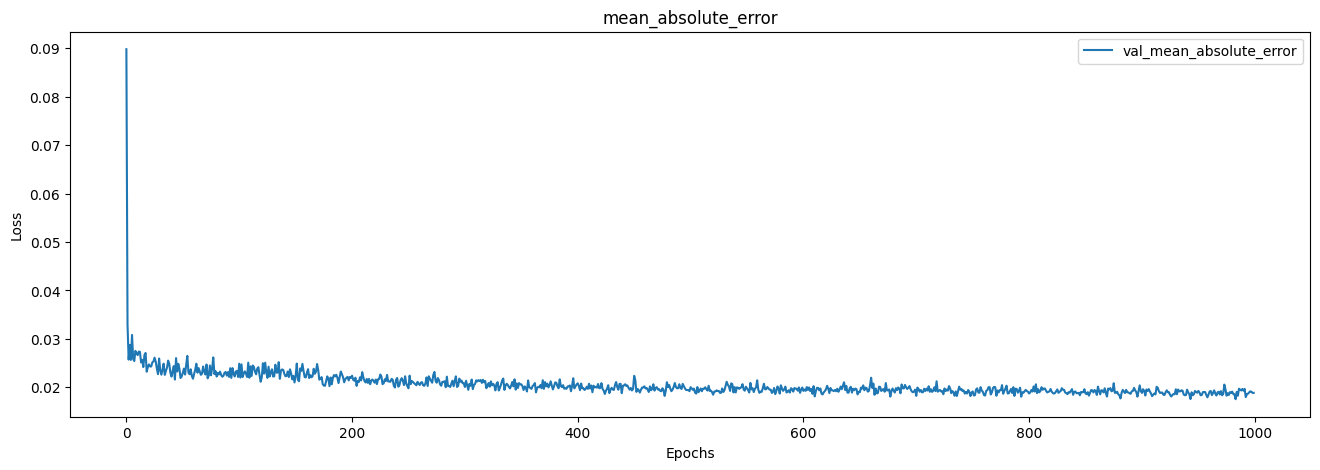

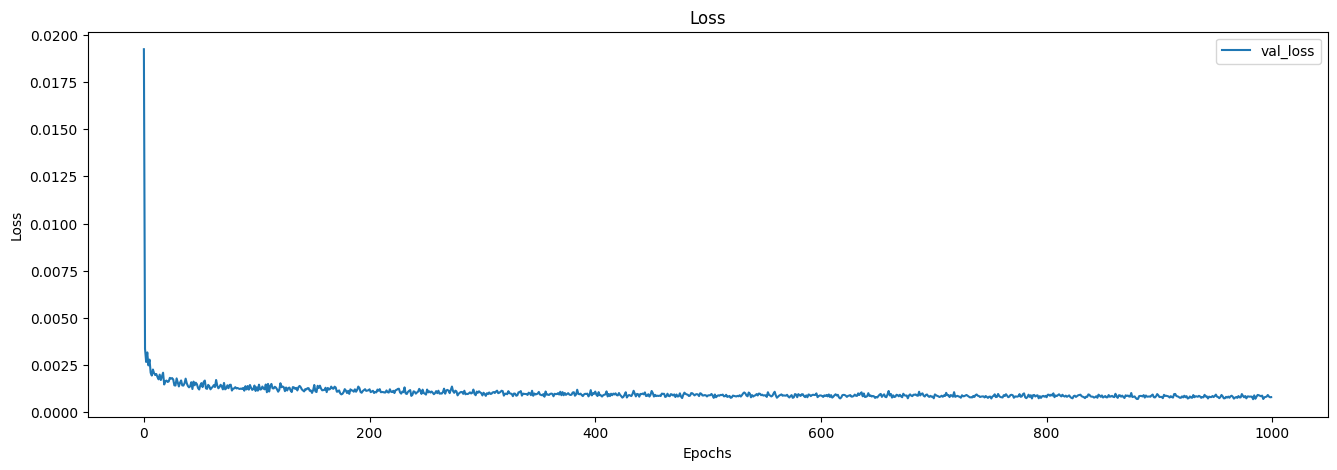

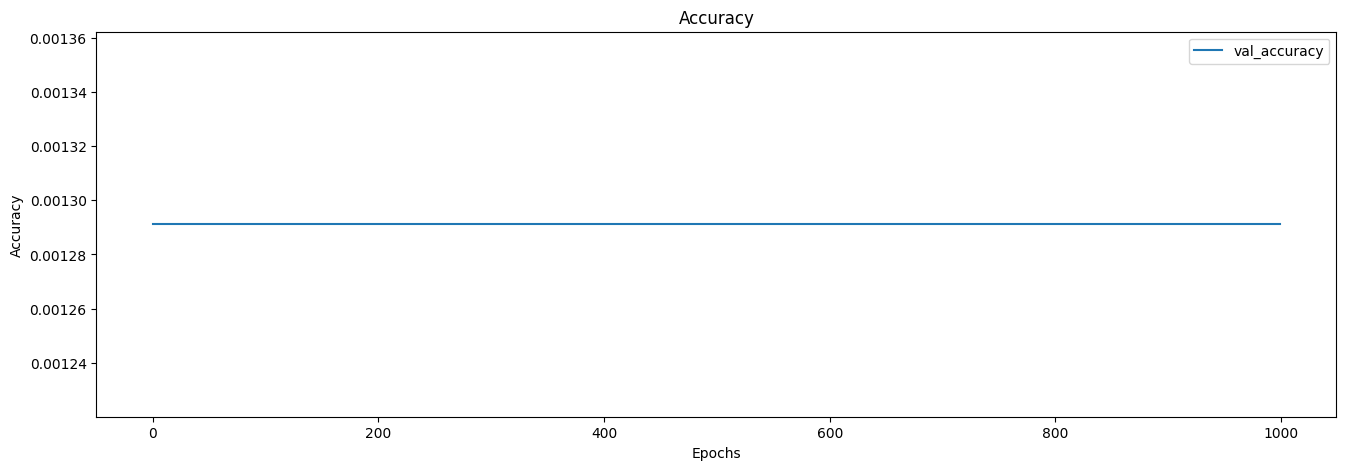

In [22]:
visualize_training_results(history)


In [23]:
# Evaluate the model on the test set
mse, accuracy, mae = model.evaluate(X_test, y_test)


13/13 [==============================] - 9s 8ms/step - loss: 3.0364e-04 - accuracy: 0.0052 - mean_absolute_error: 0.0119


In [25]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred', y_pred.shape)
print('y_test', y_test.shape)




# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


13/13 [==============================] - 0s 8ms/step
y_pred (388, 1)
y_test (388, 1)
RMSE: 0.0174
MSE: 0.0003
MAE:0.0119


In [26]:
# convert to original data
y_pred = scaler.inverse_transform(y_pred)
y_test= scaler.inverse_transform(y_test)


# evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))


MAPE: 1.5839%
RMSE: 44.0721
MSE: 1942.3474
MAE:30.1354


In [27]:
y_pred_df = pd.DataFrame(y_pred, columns=["Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=["Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')
test_dates = pd.date_range(start=test_data.index[0], end=test_data.index[-1], freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)


# Assuming y_pred is a numpy array




In [28]:

#y_test_df.to_csv("y_test_2021_2022.csv")
y_test_df

,Adj Close
Date,
2022-02-05,3014.648193
2022-02-06,3057.476074
2022-02-07,3142.470703
2022-02-08,3122.608643
2022-02-09,3239.457031
...,...
2023-02-23,1651.073853
2023-02-24,1608.373169
2023-02-25,1594.914917


In [29]:
#y_pred_df.to_csv("y_pred_2021_2022.csv")  # index=False to exclude index column in CSV
y_pred_df


,Adj Close
Date,
2022-02-05,2979.338135
2022-02-06,2975.925049
2022-02-07,3060.433594
2022-02-08,3081.856445
2022-02-09,3125.860352
...,...
2023-02-23,1670.502197
2023-02-24,1626.642944
2023-02-25,1590.930176


In [30]:

names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [31]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))


mape_value = mape(y_test, y_pred)
print(f'MAPE: {mape_value:.4f}%')


MAPE: 1.5839%


In [32]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))


smape: 1.5792%


In [34]:

# Step 1: Data cleaning

data_new = yf.download(tickers='ETH-USD', period='max', interval='1d')
data_new.dropna(inplace=True)
data_new


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2023-03-06,1564.383179,1579.456299,1557.363525,1567.398682,1567.398682,5245153345
2023-03-07,1567.424683,1579.162231,1543.127563,1561.933105,1561.933105,6854058349
2023-03-08,1561.977905,1568.175293,1534.088257,1534.088257,1534.088257,7130327525


In [35]:
data_new = data_new.drop(['Close'], axis=1)
data_new

,Open,High,Low,Adj Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984
...,...,...,...,...,...
2023-03-06,1564.383179,1579.456299,1557.363525,1567.398682,5245153345
2023-03-07,1567.424683,1579.162231,1543.127563,1561.933105,6854058349
2023-03-08,1561.977905,1568.175293,1534.088257,1534.088257,7130327525


In [37]:
future_data = data_new.iloc[-30:, :]
future_data = future_data.values
future_data = pd.DataFrame(future_data, columns=["Open", "High", "Low", "Adj Close", "Volume"])

# Get the length of future_data
future_length = future_data.shape[0]

# Generate dates for the next 30 days
today = pd.Timestamp.now().date()
future_dates = today + timedelta(days=1)

future = pd.date_range(start=future_dates, end=today +
                       timedelta(days=30), freq='D')

# Generate dates for the next 10 days for predict
today = pd.Timestamp.now().date()
future_dates_pred = pd.date_range(start=today + timedelta(days=1), periods=10, freq='D')

# Use the generated dates as the index of the DataFrame
future_data['Date'] = future

# Set the index of the dataframes to be the 'Date' column
future_data.set_index('Date', inplace=True)

future_data.tail(10)
x_future_data = future_data.drop(['Adj Close'], axis=1).values
y_future_data = future_data['Adj Close'].values
y_future_data = y_future_data.reshape(-1, 1)

print("x_future_data:", x_future_data.shape)
print("y_future_data:", y_future_data.shape)

# x_future_data= np.reshape(x_future_data, (x_future_data.shape[0], 1, x_future_data.shape[1]))

print("x_future_data:", x_future_data.shape)
x_future_data = scaler.fit_transform(x_future_data)
y_future_data = scaler.fit_transform(y_future_data)
for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]
    # future_data_temp = future_data_temp.reshape(-1, 1)
    print("future_data_temp", future_data_temp.shape)


x_future_data: (30, 4)
y_future_data: (30, 1)
x_future_data: (30, 4)
future_data_temp (30, 4)
future_data_temp (29, 4)
future_data_temp (28, 4)
future_data_temp (27, 4)
future_data_temp (26, 4)
future_data_temp (25, 4)
future_data_temp (24, 4)
future_data_temp (23, 4)
future_data_temp (22, 4)
future_data_temp (21, 4)


In [38]:

# Initialize a numpy array to store the predictions
prediction = np.zeros((10, 1))

for i in range(10):
    future_data_temp = x_future_data[i:i+30, :]

    print("future_data_temp1", future_data_temp.shape)
    future_data_temp = np.reshape(future_data_temp, (future_data_temp.shape[0],
                                                     1, future_data_temp.shape[1]))
    pred = model.predict(future_data_temp)
    print("future_data_temp2", future_data_temp.shape)
    print('---------------------------------------------------')
    prediction[i][0] = pred[0][0]
    x_future_data[i+future_data_temp.shape[0]-1][0] = pred[0][0]
print('3', future_data.shape)
print('prediction:', prediction.shape)
# Reverse the MinMaxScaler
y_future_data = y_future_data.reshape(-1, 1)
y_future_data = scaler.inverse_transform(y_future_data)
prediction = scaler.inverse_transform(prediction)

# Create a new dataframe with the predicted values and the dates as the index
prediction_df = pd.DataFrame(
    prediction, index=future_dates_pred, columns=['Adj Close'])
print('y_future_data', y_future_data.shape)
# Get the length of future_data

y_future_data = pd.DataFrame(y_future_data,  columns=['Adj Close'])

future_length = future_data.shape[0]
test = today - timedelta(days=future_length-1)
test_dates = pd.date_range(start=test, end=today, freq='D')
# Use the generated dates as the index of the DataFrame


y_future_data['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column

y_future_data.set_index('Date', inplace=True)


future_data_temp1 (30, 4)
1/1 [==============================] - 0s 317ms/step
future_data_temp2 (30, 1, 4)
---------------------------------------------------
future_data_temp1 (29, 4)
1/1 [==============================] - 0s 385ms/step
future_data_temp2 (29, 1, 4)
---------------------------------------------------
future_data_temp1 (28, 4)
1/1 [==============================] - 0s 466ms/step
future_data_temp2 (28, 1, 4)
---------------------------------------------------
future_data_temp1 (27, 4)
1/1 [==============================] - 0s 69ms/step
future_data_temp2 (27, 1, 4)
---------------------------------------------------
future_data_temp1 (26, 4)
1/1 [==============================] - 0s 169ms/step
future_data_temp2 (26, 1, 4)
---------------------------------------------------
future_data_temp1 (25, 4)
1/1 [==============================] - 0s 123ms/step
future_data_temp2 (25, 1, 4)
---------------------------------------------------
future_data_temp1 (24, 4)
1/1 [==========

In [39]:
prediction_df


,Adj Close
2023-03-11,1573.397939
2023-03-12,1525.218053
2023-03-13,1531.371046
2023-03-14,1519.472890
2023-03-15,1497.369800
2023-03-16,1543.831261
2023-03-17,1621.069237
2023-03-18,1668.875603
2023-03-19,1668.212186
2023-03-20,1673.331675


In [40]:
y_future_data


,Adj Close
Date,
2023-02-09,1546.438232
2023-02-10,1514.869141
2023-02-11,1539.926758
2023-02-12,1515.033691
2023-02-13,1507.165894
2023-02-14,1556.875122
2023-02-15,1673.745972
2023-02-16,1640.067627
2023-02-17,1694.783325


In [43]:
names = cycle(['Predictions next 10 day', 'Actual data '])

fig = go.Figure()

fig.add_trace(go.Scatter(x=y_future_data.index, y=y_future_data['Adj Close'], name='Actual data ',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='blue')))

fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=y_future_data.index[-1], y1=y_future_data['Adj Close'][-1],
              line=dict(color='grey', width=2))
fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()


In [44]:
actual_x = y_future_data.index
actual_y = y_future_data['Adj Close']
pred_x = prediction_df.index
pred_y = prediction_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_x, y=actual_y, name='Actual Data'))
fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
              name='Predictions Data for 10 day'))

fig.add_shape(type='line',
              x0=actual_x[-1], y0=actual_y[-1],
              x1=pred_x[0], y1=pred_y[0],
              line=dict(color='grey', width=2, dash='dot'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='predict next 10 day '
)

fig.show()


In [45]:
future_data_all = data_new.copy()

future_data_all = pd.DataFrame(future_data_all, index= future_data_all.index, 
                               columns=future_data_all.columns)

x_future_data_all = future_data_all.drop(['Adj Close'], axis=1).values
y_future_data_all = future_data_all['Adj Close'].values
y_future_data_all = y_future_data_all.reshape(-1, 1)

print("x_future_data:", x_future_data_all.shape)
print("y_future_data:", y_future_data_all.shape)


x_future_data: (1948, 4)
y_future_data: (1948, 1)


In [46]:
x_future_data_all = scaler.fit_transform(x_future_data_all)
y_future_data_all = scaler.fit_transform(y_future_data_all)

x_future_data_all = np.reshape(x_future_data_all, (x_future_data_all.shape[0], 1, x_future_data_all.shape[1]))

pred_future_all = model.predict(x_future_data_all)


61/61 [==============================] - 1s 9ms/step


In [47]:

y_future_data_all = scaler.inverse_transform(y_future_data_all)
pred_future_all = scaler.inverse_transform(pred_future_all)
y_future_all = pd.DataFrame(y_future_data_all, index= future_data_all.index,  columns=['Adj Close'])
pred_future_all_df = pd.DataFrame(pred_future_all, index= future_data_all.index,  columns=['Adj Close'])
print("pred_future_all:", pred_future_all.shape)
print("y_future_data:", y_future_data_all.shape)

pred_future_all: (1948, 1)
y_future_data: (1948, 1)


In [48]:
names = cycle(['Predictions', 'Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_future_all.index, y=pred_future_all_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_future_all.index, y=y_future_all['Adj Close'], name='Actual Data',
                         line=dict(width=2, color='red')))
fig.add_trace(go.Scatter(x=prediction_df.index, y=prediction_df['Adj Close'], name='Predictions next 10 day',
                         line=dict(width=2, color='gray')))
fig.add_shape(type='line',
              x0=prediction_df.index[0], y0=prediction_df['Adj Close'][0],
              x1=pred_future_all_df.index[-1], y1=pred_future_all_df['Adj Close'][-1],
              line=dict(color='grey', width=2))

fig.update_layout(xaxis_title='Date', yaxis_title='Price',
                  font_size=15, font_color='black', legend_title_text=' Parameters')
fig.show()
